# Setup

In [1]:
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd '/content/drive/MyDrive/kaggle/competition_practice/dacon-작가분류'

/content/drive/MyDrive/kaggle/competition_practice/dacon-작가분류


In [3]:
import os 
import gc 
import copy 
import glob 

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd 

import easydict 
from tqdm import notebook

# image 
from PIL import Image

# visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns  

# pytorch 
import torch 
from torch.utils.data import Dataset 
from torch.utils.data import DataLoader 

import torch.nn as nn 
import torch.nn.functional as F 
from torch.optim import Adam, AdamW 

from torch.optim.lr_scheduler import ReduceLROnPlateau

from torchvision import transforms

from sklearn import preprocessing

In [4]:
!pip install timm 
import timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Data 

In [6]:
project_path = '/content/drive/MyDrive/kaggle/competition_practice/dacon-작가분류'

In [7]:
# !unzip -qq '/content/drive/MyDrive/kaggle/competition_practice/dacon-작가분류/dataset.zip'

In [8]:
len_train = list(glob.glob('/content/drive/MyDrive/kaggle/competition_practice/dacon-작가분류/train/*.jpg'))
len_test = list(glob.glob('/content/drive/MyDrive/kaggle/competition_practice/dacon-작가분류/test/*.jpg'))

print('# of image of train : {} / # of image of test : {}'.format(len(len_train), len(len_test)))

# of image of train : 5911 / # of image of test : 12670


In [9]:
# path 
train_path = os.path.join(project_path, 'train')
test_path = os.path.join(project_path, 'test')

In [10]:
# artists info 
artists = pd.read_csv(project_path + '/artists_info.csv')
artists.head()

,name,years,genre,nationality
0,Amedeo Modigliani,1884 - 1920,Expressionism,Italian
1,Vasiliy Kandinskiy,1866 - 1944,"Expressionism,Abstractionism",Russian
2,Diego Rivera,1886 - 1957,"Social Realism,Muralism",Mexican
3,Claude Monet,1840 - 1926,Impressionism,French
4,Rene Magritte,1898 - 1967,"Surrealism,Impressionism",Belgian


In [11]:
#  Label Encoding
train_df = pd.read_csv(os.path.join(project_path + '/train.csv'))
le = preprocessing.LabelEncoder()
train_df['label'] = le.fit_transform(train_df['artist'].values)

# label, index 
idx2label = train_df[['artist', 'label']].drop_duplicates().reset_index(drop = True).to_dict()['artist']
label2idx = {v: k for k, v in idx2label.items()}

del train_df['artist']

In [12]:
# test
labels = [] 

for path in os.walk(test_path) : 
  base_path = path[0] # image directory
  images = path[2] # file names 

  for image in images : 
    img_path = os.path.join(base_path, image)
    label = {'img_path' : img_path, 
             'label' : -1}

    labels.append(label)

test_df = pd.DataFrame(labels)
test_df = test_df.sort_values(['img_path'])
test_df.reset_index(drop = True, inplace = True)
test_df.head()

,img_path,label
0,/content/drive/MyDrive/kaggle/competition_prac...,-1
1,/content/drive/MyDrive/kaggle/competition_prac...,-1
2,/content/drive/MyDrive/kaggle/competition_prac...,-1
3,/content/drive/MyDrive/kaggle/competition_prac...,-1
4,/content/drive/MyDrive/kaggle/competition_prac...,-1


In [13]:
# test
labels = [] 

for path in os.walk(test_path) : 
  base_path = path[0] # image directory
  images = path[2] # file names 

  for image in images : 
    img_path = os.path.join(base_path, image)
    label = {'img_path' : img_path, 
             'label' : -1}

    labels.append(label)

test_df = pd.DataFrame(labels)
test_df = test_df.sort_values(['img_path'])
test_df.reset_index(drop = True, inplace = True)
test_df.head()

,img_path,label
0,/content/drive/MyDrive/kaggle/competition_prac...,-1
1,/content/drive/MyDrive/kaggle/competition_prac...,-1
2,/content/drive/MyDrive/kaggle/competition_prac...,-1
3,/content/drive/MyDrive/kaggle/competition_prac...,-1
4,/content/drive/MyDrive/kaggle/competition_prac...,-1


# EDA 

In [14]:
import os 

num_train = len(os.listdir('train/'))
num_test = len(os.listdir('test/'))

print(f'# of train : {num_train}')
print(f'# of test : {num_test}')

# of train : 5911
# of test : 12670


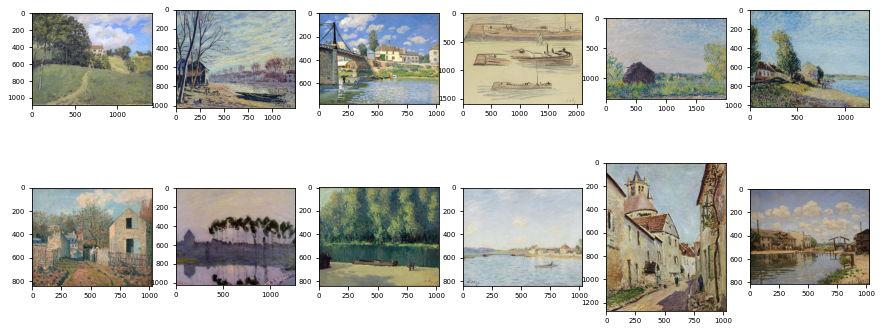

In [15]:
import matplotlib.gridspec as gridspec
import cv2

mpl.rc('font', size = 7)
plt.figure(figsize = (15, 6))
grid = gridspec.GridSpec(2, 6)

# 선인장을 포함하는 이미지 파일명(마지막 12개)
last_has_cactus_img_name =  train_df[train_df['label'] == 1]['img_path'][-12:]
last_has_cactus_img_name

for idx, img_name in enumerate(last_has_cactus_img_name) : 
  img_path = '' + img_name # 이미지 파일 경로
  image = cv2.imread(img_path) # 이미지 파일 읽어오기
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # 이미지 색상 보정
  ax = plt.subplot(grid[idx]) 
  ax.imshow(image) # 이미지 출력

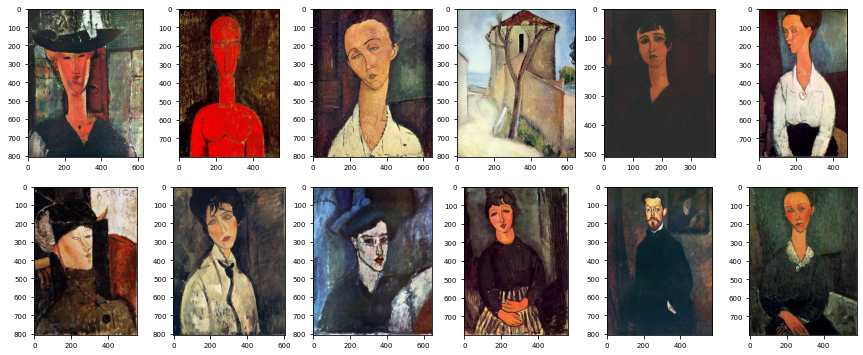

In [16]:
import matplotlib.gridspec as gridspec
import cv2

mpl.rc('font', size = 7)
plt.figure(figsize = (15, 6))
grid = gridspec.GridSpec(2, 6)

# 선인장을 포함하는 이미지 파일명(마지막 12개)
last_has_cactus_img_name =  train_df[train_df['label'] == 2]['img_path'][-12:]
last_has_cactus_img_name

for idx, img_name in enumerate(last_has_cactus_img_name) : 
  img_path = '' + img_name # 이미지 파일 경로
  image = cv2.imread(img_path) # 이미지 파일 읽어오기
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # 이미지 색상 보정
  ax = plt.subplot(grid[idx]) 
  ax.imshow(image) # 이미지 출력

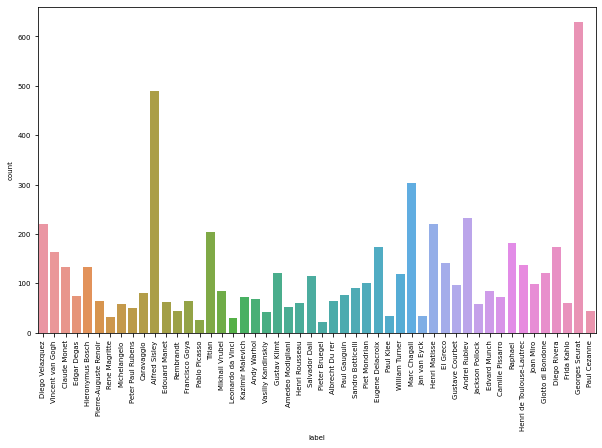

In [17]:
plt.figure(figsize = (10, 6))
p = sns.countplot(train_df['label'])
p.set_xticklabels(list(label2idx.keys()))
p.set_xticklabels(p.get_xticklabels(), rotation=90)
plt.show()

# Dataset & DataLoader

In [21]:
from sklearn.model_selection import train_test_split 

# 훈련 데이터, 검증 데이터 분리
train, valid = train_test_split(train_df,
                                test_size = .1, 
                                stratify = train_df['label'],
                                random_state = 50)

print(f'# of train data : {len(train)}')
print(f'# of valid data : {len(valid)}')

# of train data : 5319
# of valid data : 592


In [22]:
import cv2 
from torch.utils.data import Dataset # 데이터 생성을 위한 클래스

class CustomDataset(Dataset) : 
  # 초기화 메서드 (생성자)
  def __init__(self, df, img_dir = '', transform = None) : 
    super().__init__() # 상속받은 Dataset의 생성자 호출
    
    # 전달받은 인수들 저장
    self.df = df
    self.img_dir = img_dir
    self.transform = transform

  # 데이터셋 크기 반환 메서드
  def __len__(self) :
    return len(self.df)

  # 인덱스에 해당하는 데이터 반환 메서드
  def __getitem__(self, idx) : 
    img_id = self.df.iloc[idx, 1]
    img_path = self.img_dir + img_id
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    label = self.df.iloc[idx, 2]

    if self.transform is not None : 
      image = self.transform(image)
    return image, label

In [23]:
from torchvision import transforms 

# 훈련 데이터용 변환기
transform_train = transforms.Compose([transforms.ToTensor(), # 이미지를 텐서 객체로 변환
                                      transforms.Resize((224, 224)), 
                                      transforms.RandomHorizontalFlip(), # 좌우 대칭(변환할 이미지의 비율 지정할 수 있으며, 지정하지 않으면 50%)
                                      transforms.RandomVerticalFlip(), # 상하 대칭(변환할 이미지의 비율 지정할 수 있으며, 지정하지 않으면 50%)
                                      transforms.RandomRotation(10), # 이미지 회전 (파라미터로 n을 전달하면 -n도 ~ n도 사이의 값만큼 무작위로 회전)
                                      transforms.Normalize((0.485, 0.456, 0.406), # R, G, B 채널에 전달할 평균과 분산으로 ImageNet으로부터 구해진 값
                                                             (0.229, 0.224, 0.225))]) 

# 검증 및 테스트 데이터용 변환기 
transform_test = transforms.Compose([transforms.ToTensor(), # 이미지를 텐서 객체로 변환
                                     transforms.Resize((224, 224)), 
                                     transforms.Normalize((0.485, 0.456, 0.406),
                                                          (0.229, 0.224, 0.225))])

In [24]:
# 데이터셋 
dataset_train = CustomDataset(df = train, transform = transform_train)
dataset_valid = CustomDataset(df = valid, transform = transform_test)

# 데이터 로더
from torch.utils.data import DataLoader
loader_train = DataLoader(dataset = dataset_train, batch_size = 32, shuffle = True)
loader_valid = DataLoader(dataset = dataset_valid, batch_size = 32, shuffle = False)

## model

In [25]:
import math
def input_output(n_input, n_padding, n_kernel, n_stride) :
  out1 = math.floor((n_input + 2 * n_padding - n_kernel)/n_stride) + 1
  out2 = math.floor(out1/2) 
  return out1, out2

In [26]:
print(input_output(224, 2, 3, 1))
print(input_output(113, 2, 3, 1))
print(input_output(57, 2, 3, 1))
print(input_output(29, 2, 3, 1))
print(input_output(15, 2, 3, 1))

(226, 113)
(115, 57)
(59, 29)
(31, 15)
(17, 8)


In [27]:
import torch.nn as nn 
import torch.nn.functional as F 

class Model(nn.Module) : 
  def __init__(self) : 
    super().__init__()
    self.layer1 = nn.Sequential(nn.Conv2d(in_channels = 3, out_channels = 32,
                                          kernel_size = 3, padding = 2),
                                nn.BatchNorm2d(32),
                                nn.LeakyReLU(),
                                nn.MaxPool2d(kernel_size = 2))
      
    self.layer2 = nn.Sequential(nn.Conv2d(in_channels = 32, out_channels = 64,
                                          kernel_size = 3, padding = 2),
                                nn.BatchNorm2d(64),
                                nn.LeakyReLU(),
                                nn.MaxPool2d(kernel_size = 2))
    
    self.layer3 = nn.Sequential(nn.Conv2d(in_channels = 64, out_channels = 128,
                                          kernel_size = 3, padding = 2),
                                nn.BatchNorm2d(128),
                                nn.LeakyReLU(),
                                nn.MaxPool2d(kernel_size = 2))
    
    self.layer4 = nn.Sequential(nn.Conv2d(in_channels = 128, out_channels = 256,
                                          kernel_size = 3, padding = 2),
                                nn.BatchNorm2d(256),
                                nn.LeakyReLU(),
                                nn.MaxPool2d(kernel_size = 2))
    
    self.layer5 = nn.Sequential(nn.Conv2d(in_channels = 256, out_channels = 512,
                                          kernel_size = 3, padding = 2),
                                nn.BatchNorm2d(512),
                                nn.LeakyReLU(),
                                nn.MaxPool2d(kernel_size = 2))
    
    # 평균 풀링 계층
    self.avg_pool = nn.AvgPool2d(kernel_size = 8)

    # 전결합 계층
    self.fc1 = nn.Linear(in_features = 512 * 1 * 1, out_features = 128)
    self.fc2 = nn.Linear(in_features = 128, out_features = 50)

  # 순전파 출력 정의    
  def forward(self, x) :
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)
    x = self.layer5(x)
    x = self.avg_pool(x)
    x = x.view(-1, 512 * 1 * 1)
    x = self.fc1(x)
    x = self.fc2(x)
    return x


In [28]:
model = Model().to(device)

## loss & optimizer

In [30]:
# loss function 
criterion = nn.CrossEntropyLoss().to(device)

# optimizer 
optimizer = torch.optim.Adamax(model.parameters(), lr = 0.0001)

## train

In [31]:
epochs = 1

for epoch in range(epochs) :
  epoch_loss = 0

  for images, labels in loader_train : 
    images = images.to(device)
    labels = labels.to(device)

    # 기울기 초기화
    optimizer.zero_grad()

    # 순전파
    outputs = model(images)

    # 손실 계산 
    loss = criterion(outputs, labels)

    # 손실 추가
    epoch_loss += loss.item()

    # 역전파
    loss.backward()

    # 가중치 갱신
    optimizer.step()

  # 에폭마다 손실값 출력
  print(f'epoch [{epoch + 1} / {epochs}] - loss : {epoch_loss / len(loader_train):.4f}')

epoch [1 / 1] - loss : 3.3216


In [32]:
from sklearn.metrics import f1_score

true_list = [] 
preds_list = [] 

model.eval()

with torch.no_grad() :
  for images, labels in loader_valid : 
    images = images.to(device)
    labels = labels.to(device)

    outputs = model(images)
    preds = list(map(idx2label.get, outputs.argmax(1).tolist()))
    true = list(labels.tolist())

    preds_list.extend(preds)
    true_list.extend(true)

true_list = [idx2label[idx] for idx in true_list]
f1_score(true_list, preds_list, average = 'macro')

In [33]:
# test
labels = [] 

for path in os.walk(test_path) : 
  base_path = path[0] # image directory
  images = path[2] # file names 

  for image in images : 
    img_path = os.path.join(base_path, image)
    label = {'img_path' : img_path, 
             'label' : -1}

    labels.append(label)

test_df = pd.DataFrame(labels)
test_df = test_df.sort_values(['img_path'])
test_df.reset_index(drop = True, inplace = True)

test_df.reset_index(inplace = True)
test_df.rename(columns = {'index' : 'id'}, inplace = True)
test_df.head()

,id,img_path,label
0,0,/content/drive/MyDrive/kaggle/competition_prac...,-1
1,1,/content/drive/MyDrive/kaggle/competition_prac...,-1
2,2,/content/drive/MyDrive/kaggle/competition_prac...,-1
3,3,/content/drive/MyDrive/kaggle/competition_prac...,-1
4,4,/content/drive/MyDrive/kaggle/competition_prac...,-1


In [40]:
len(loader_test) * 32

12672

In [41]:
submission = pd.read_csv(project_path + '/sample_submission.csv')

dataset_test = CustomDataset(df = test_df, transform = transform_test)
loader_test = DataLoader(dataset = dataset_test, batch_size = 32, shuffle = False)

model.eval()
preds_list = [] 

with torch.no_grad() : 
  for images, _ in loader_test : 
    images = images.to(device)

    outputs = model(images)
    preds = list(map(idx2label.get, outputs.argmax(1).tolist()))
    preds_list.extend(preds)

submission['artist'] = preds_list

In [42]:
len(preds_list)

12670

In [43]:
len(submission)

12670

In [44]:
len(test_df)

12670

In [45]:
submission

,id,artist
0,TEST_00000,Raphael
1,TEST_00001,Alfred Sisley
2,TEST_00002,Alfred Sisley
3,TEST_00003,Diego Velazquez
4,TEST_00004,Alfred Sisley
...,...,...
12665,TEST_12665,Alfred Sisley
12666,TEST_12666,Alfred Sisley
12667,TEST_12667,Alfred Sisley
12668,TEST_12668,Raphael


In [46]:
submission.to_csv('submission.csv', index = False)